In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import math
import numpy as np
import pandas as pd
import random
import json
import copy
import sentencepiece as spm
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm


random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# 1. 데이터 분석

> 본 1장에서는 BERT 모델에 활용할 데이터를 메모리에 적재하고 데이터의 구성 정보를 확인하는 과정을 기술한다.<br>
> 해당 데이터는 '나무위키' 사이트에서 주제별 문서를 수집하여, 635MB 규모의 한국어 데이터를 활용한다.<br>
> <br>
> [출처 - 나무위키](https://namu.wiki/w/%EB%82%98%EB%AC%B4%EC%9C%84%ED%82%A4:%EB%8C%80%EB%AC%B8)

In [2]:
corpus_file_path = './Data/lecture14/data/kowiki.txt'

In [3]:
def load_dataset(file_path):
    data_set = None
    with open(file_path, 'r') as f:
        data_set = f.read().splitlines()
        
    return data_set

In [4]:
kowiki_data = load_dataset(corpus_file_path)

In [5]:
print(f'문장 개수 : {len(kowiki_data)} 개\n')
print(kowiki_data[:5])

문장 개수 : 3957766 개

['지미 카터', '제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.', '지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.', '1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.', '1976년 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워, 포드를 누르고 당선되었다.']


> 3,957,766개의 문장이 있으며, 주제 별 상세 내용이 기재되어있음을 확인할 수 있다.

# 2. sentence piece 기반 토크나이저

> 수집한 데이터를 sentence piece 기반으로 토크나이저 객체를 생성하고 객체의 구성 정보를 확인하는 과정을 기술한다.

# 2.1 sentence piece 생성

> 단어 토큰 8,000 개, 특수 토큰 7개으로 구성된 총 8,007개의 토큰을 가진 sentence piece 모델 객체를 생성한다.

In [6]:
prefix = 'ko_8000' # sentence pice 모델 이름
vocab_size = 8000  # 단어사전 크기

In [7]:
spm.SentencePieceTrainer.train(
    f"--input={corpus_file_path} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

# 2.2 생성한 sentence piece model 확인

> 이전에 수행한 sentence piece 모델을 로드 후, 10개의 토큰을 출력하여 구성 내용을 확인한다.

In [7]:
data_dir = './Data/lecture14/data'
model_dir = './Data/lecture14/models'

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

True

In [9]:
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))
        
print(vocab_list[:10])

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']


# 3. Data Preporcessing

> BERT 모델에 활용되는 훈련 프로세스인 Masked-Language model과 Next Sentence Prediction를 구현한다.<br>
> 구현된 MLM, NSP를 활용하여  BERT 모델에 사용할 pretrain 데이터를 생성후 결과를 확인하는 과정을 기술한다.

## 3.1 Create MAKS

> Masked-Language model, 이하 MLM은 BERT 모델에 활용되는 훈련 프로세스 중 하나이다.<br>
> 기존 BERT에 문장을 입력했을 때 BERT 내부의 가중치를 최적화하여 반대쪽에 동일한 문장을 출력하는 것으로 구성한다.<br>
> MLM는 BERT에 문장 정보를 제공하기 전에 몇 개의 토큰을 마스킹하여 제공한다.<br>
> 이는 일부 단어가 제거된 불완전한 문장을 입력하여 Masking된 토큰의 다음 단어를 예측할 수 있도록 BERT 모델을 학습시키는 것이다.<br>
> <br>
> 전체 토큰의 30%를 마스킹하여 MLM을 구성한다. 이때, 문장 입력 시 랜덤하게 Masking을 수행한다.<br>
> <br>
> [출처 - Masked-Language Modeling With BERT](https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c)

In [10]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    # step1. 단어 단위로 mask 하기위한 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
            
    # step2. random mask를 위한 순서 섞기
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 30%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 30%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
            
    # step3. mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

> 구현한 MNM의 정상 작동 여부를 확인하기위해, 예문을 입력하여 테스트를 진행한다.

In [11]:
tokens_org = vocab.encode_as_pieces("미국이 금리를 인상할 예정이었으나 계획이 취소되었다.")

mask_cnt = int((len(tokens_org)) * 0.3)
tokens, mask_idx, mask_label = create_pretrain_mask(tokens_org, mask_cnt, vocab_list)

print(f"원문 : {tokens_org}")
print(f"Masking 된 문장 : {tokens}")
print(f"maks index : {mask_idx}")
print(f"mask label : {mask_label}")

원문 : ['▁미국', '이', '[MASK]', '[MASK]', '▁인', '상', '할', '▁예정', '이었', '으나', '[MASK]', '[MASK]', '▁취', '소', '되었다', '.']
Masking 된 문장 : ['▁미국', '이', '[MASK]', '[MASK]', '▁인', '상', '할', '▁예정', '이었', '으나', '[MASK]', '[MASK]', '▁취', '소', '되었다', '.']
maks index : [2, 3, 10, 11]
mask label : ['▁금', '리를', '▁계획', '이']


> 정상적으로  예문의 단어 토큰 중 30%가 Mask 처리된 모습을 확인할 수 있다.

## 3.2 Create NSP pair

> Next Sentence Prediction, 이하 NSP은 BERT 모델에 활용되는 훈련 프로세스 중 하나이다.<br>
> NSP는 BERT에게 문장 간의 장기적인 종속성을 이해하도록 학습시키는 알고리듬이다.<br> 
> 이를 위해 BERT에 A문장과 B문장이라는 두 개의 문장을 주는 것으로 구성하여, B문장이 A문장 다음에 오는지 체크한다.<br>
> 이후 BERT는 IsNextSentence(True)또는 NotNextSentence(False)를 출력한다.<br>
> <br>
> 문장의 단어 토큰의 길이를 제한하는 함수를 활용하여 NSP 데이터를 생성하는 함수를 구현한다.<br>
> <br>
> [출처 - BERT For Next Sentence Prediction](https://towardsdatascience.com/bert-for-next-sentence-prediction-466b67f8226f)

In [12]:
# 단어 토큰 길이 전처리
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [32]:
# NSP 데이터 생성
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens)-3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
            
    return instances

> 구현한 NSP의 정상 작동 여부를 확인하기위해, 예문을 입력하여 테스트를 진행한다.

In [33]:
ex_sentence = ['미국이 금리를 인상할 예정이었으나 계획이 취소되었다.','다음날 코스피는 상승캔들로 장이 마감되었다.']
doc = list()

for sentence in ex_sentence:
    doc.append(vocab.encode_as_pieces(sentence))

n_seq = 64
mask_prob = 0.3

result = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)

print(f'단어 토큰 : {result[0].get("tokens")}', end="\n\n")
print(f'세그먼트 : {result[0].get("segment")}', end="\n\n")
print(f'종속 여부(True:1, False:0) : {result[0].get("is_next")}', end="\n\n")
print(f'mask index : {result[0].get("mask_idx")}', end="\n\n")
print(f'mask label : {result[0].get("mask_label")}', end="\n\n")

단어 토큰 : ['[CLS]', '▁미국', '이', '▁금', '리를', '▁인', '상', '할', '▁예정', '이었', '으나', '▁계획', '이', '▁취', '소', '되었다', '.', '[SEP]', '▁다음', '날', '▁코', '스', '피', '는', '▁상', '승', '캔', '들로', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[SEP]']

세그먼트 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

종속 여부(True:1, False:0) : 1

mask index : [3, 4, 28, 29, 30, 31, 32, 33]

mask label : ['▁금', '리를', '▁장', '이', '▁마', '감', '되었다', '.']



## 3.3 Create Pretrain Dataset

> <code>MNM</code>과 <code>NSP</code> 함수를 활용하여 BERT 모델에 사용할 pretrain 데이터를 생성한다.

In [34]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.3):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

In [35]:
def check_line_count(file_path):
    total = 0
    with open(file_path, 'r') as in_f:
        for line in in_f:
            total += 1

    return total

In [36]:
pretrain_json_path = './Data/lecture14/data/bert_pre_train.json'
make_pretrain_data(vocab, corpus_file_path, pretrain_json_path, n_seq=128, mask_prob=0.3)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [37]:
print(f'말뭉치 데이터 문장 개수 : {check_line_count(corpus_file_path)} 개')
print(f'Pretrain 학습 데이터 문장 개수 : {check_line_count(out_file)} 개')

말뭉치 데이터 문장 개수 : 3957761 개
Pretrain 학습 데이터 문장 개수 : 918189 개


> 기존 약 400만개의 말뭉치 데이터를 pretrain하여 약 92만개(기존 대비 23.1%)의 규모로 데이터를 구성하였다. 

## 3.4 Load Pretrain Dataset

> <code>out_file</code> 경로에 저장한 pretrain 데이터셋은 파일 용량이 1.58GB이다.<br>
> <code>np.memmap</code>을 활용하여 메모리 사용량을 최소화함으로써 용량이 큰 pretrain 데이터셋을 효율적으로 사용하고자한다.<br>
> 모델의 학습 속도를 높이기 위하여 <code>pretrain</code>의 모든 데이터(918,189개) 중 약 14%의 데이터(128,000개)만 사용한다.

In [38]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [40]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

data load early stop 128000 128000


## 3.5 Create Train, Test dataset

> BERT 모델 학습에 사용할 Train 데이터와 모델 평가에 활용할 Test 데이터를 생성한다.

In [63]:
print(type(pre_train_inputs))
print(type(pre_train_labels))
print(pre_train_inputs[0].shape)
print(pre_train_inputs[1].shape)
print(pre_train_labels[0].shape)
print(pre_train_labels[1].shape)

<class 'tuple'>
<class 'tuple'>
(128000, 128)
(128000, 128)
(128000,)
(128000, 128)


In [64]:
pre_test_input = (pre_train_inputs[0][:100], pre_train_inputs[1][:100])
pre_test_label = (pre_train_labels[0][:100], pre_train_labels[1][:100])
pre_train_inputs = (pre_train_inputs[0][100:], pre_train_inputs[1][100:])
pre_train_labels = (pre_train_labels[0][100:], pre_train_labels[1][100:])

# 4. BERT 모델 구현

> BERT 모델은 Self-Attention 으로 이루어진 Encoder-Decoder 구조를 가진 Transformer모델과 흡사하지만 Transformer Encoder 구조만을 활용하는 모델로, 아래 그림과 같이 3개의 embedding 레이어로 구성되어있다.

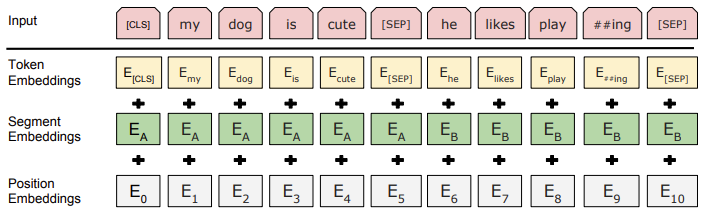

## 4.1 Utility Function

> BERT 모델을 구현함에 있어 편의성을 위한 유틸성 사용자 정의 함수들을 구현한다

In [65]:
# pad mask 계산하는 함수
def get_pad_mask(tokens, i_pad=0):
    """
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

# ahead mask 계산하는 함수
def get_ahead_mask(tokens, i_pad=0):
    """
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

# gelu activation 함수
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


# parameter initializer 생성 함수
def kernel_initializer(stddev=0.02):
    """
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

# bias initializer 생성 함수
def bias_initializer():
    return tf.zeros_initializer


# json을 config 형태로 사용하기 위한 Class
class Config(dict):
    """
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함수
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

## 4.2 Weighed shared embedding class

> BERT의 모델에서 가중치를 공유하도록하는 임베딩 레이어 클래스를 구현한다.

In [66]:
class SharedEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

## 4.3 Positional embedding class

> Transformer에서 사용되던 position embedding과 동일한 기능을 수행하는 임베딩 레이어 클래스를 구현한다.

In [67]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

## 4.4 Scale dot product attention class

> Transformer에서 사용되던 Scale dot product attention과 동일한 기능을 수행하는 어텐션 클래스를 구현한다.

In [68]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

## 4.5 Multi head attention class

> Transformer에서 사용되던 Multi head attention과 동일한 기능을 수행하는 어텐션 클래스를 구현한다.

In [69]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

## 4.6 Position wise feed forward class

> Transformer에서 사용되던 feed forward network과 동일한 기능을 수행하는 Position wise feed forward 클래스를 구현한다.

In [70]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

## 4.7 Encoder layer class

> 위 4.1 ~ 4.6 장에서 구현한 클래스를 활용하여 BERT 모델의 인코더 레이어 클래스를 구현한다.

In [71]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

## 4.8 BERT model class

> 4.1~ 4.7장의 클래스를 활용하여 BERT 모델을 구현하는 클래스를 구현한다.

In [73]:
class BERT(tf.keras.layers.Layer):

    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

# 5. Pretrain BERT model

> BERT 레이어를 바탕으로 pretrain 데이터를 학습하는 BERT 모델 구현하고 인스턴스 객체를 생성하는 과정을 기술한다.

## 5.1 Pretrain BERT model for BERT layer

> BERT 레이어를 바탕으로 pretrain 데이터를 학습하는 BERT 모델을 설계한다.

In [74]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(
            config.d_model, activation=tf.nn.tanh,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer())
        
        self.dense2 = tf.keras.layers.Dense(
            n_output, use_bias=False, activation=tf.nn.softmax, name="nsp",
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
    
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

## 5.2 Set calculation function

> BERT 모델의 loss와 accuracy를 계산하고 Learning Rate를 설정하는 함수를 구현한다.

In [79]:
# Loss계산 함수
def lm_loss(y_true, y_pred):
    """
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

# Accuracy 계산 함수
def lm_acc(y_true, y_pred):
    """
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

> <code>CosineSchedule</code>를 활용하여 초기에는 학습률이 높으나, 학습이 진행됨에 따라 점진적으로 낮아지는 클래스를 구현한다.

In [80]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

## 5.3 Create pretrain BERT model

> BERT 모델의 하이퍼 파라미터를 설정한 후 <code>build_model_pre_train()</code>활용하여 BERT 객체를 생성한다.<br>
> BERT model 객체는 5,340,672개의 학습 파라미터로 구성되어있다.

In [77]:
config = Config({"d_model": 256, 
                 "n_head": 8, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 1024, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 3, 
                 "n_seq": 256, 
                 "n_vocab": 0, 
                 "i_pad": 0})

config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()

In [78]:
pre_train_BERT_model = build_model_pre_train(config)
pre_train_BERT_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 5274368     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

# 6. Train BERT model

> 모델 학습 이전에 훈련 횟수와 배치 사이즈, 옵티마이저, 학습률, 손실 함수을 정의한다.<br>
> 이후, 모델을 학습을 진행하며 각 epoch당 모델의 훈련 성능을 확인하는 과정을 기술한다.

## 6.1 Setting optimizer

> 훈련 횟수는 10회이며, 배치 사이즈는 64, 옵티마이저는 'Adam'로 설정한다.<br>
> 학습률은 초기에는 높으나 학습이 진행됨에 따라 점점 낮아지도록 가변적으로 설정한다.

In [83]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_BERT_model.compile(
    loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss),
    optimizer=optimizer,
    metrics={"nsp": "acc", "mlm": lm_acc})

## 6.2 train model

> BERT 모델은 학습에 많은 시간이 소요되므로,check_point를 설정하여 학습 중간에 모델을 저장하도록 설정한다.

In [84]:
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train128000.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)

In [85]:
history = pre_train_BERT_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
1999/1999 [==============================] - 601s 297ms/step - loss: 42.1520 - nsp_loss: 0.6671 - mlm_loss: 41.4849 - nsp_acc: 0.5735 - mlm_lm_acc: 0.1056

Epoch 00001: mlm_lm_acc improved from -inf to 0.11378, saving model to ./Data/lecture14/models/bert_pre_train128000.hdf5
Epoch 2/10
1999/1999 [==============================] - 595s 298ms/step - loss: 35.1687 - nsp_loss: 0.6292 - mlm_loss: 34.5395 - nsp_acc: 0.6099 - mlm_lm_acc: 0.1301

Epoch 00002: mlm_lm_acc improved from 0.11378 to 0.13218, saving model to ./Data/lecture14/models/bert_pre_train128000.hdf5
Epoch 3/10
1999/1999 [==============================] - 595s 298ms/step - loss: 32.6497 - nsp_loss: 0.6188 - mlm_loss: 32.0308 - nsp_acc: 0.6186 - mlm_lm_acc: 0.1471

Epoch 00003: mlm_lm_acc improved from 0.13218 to 0.15921, saving model to ./Data/lecture14/models/bert_pre_train128000.hdf5
Epoch 4/10
1999/1999 [==============================] - 595s 298ms/step - loss: 28.5273 - nsp_loss: 0.6143 - mlm_loss: 27.9130 - n

> 모델을 10회 반복훈련한 결과는 다음과 같다.<br>
> <br>
> loss: 25.1228<br>
> nsp_loss: 0.5983<br>
> mlm_loss: 24.5245<br>
> nsp_acc: 0.6515<br>
> mlm_lm_acc: 0.2428<br>

# 7. Result

> 6장에서 학습된 BERT 모델의 학습 과정을 시각화하여 확인하고, 테스트 데이터를 활용하여 모델의 성능을 평가하는 과정을 기술한다.

## 7.1 모델 학습 과정 시각화

> <code>history</code>변수에 저장된 모델의 학습 기록 수치데이터를 그래프로 시각화하여 확인한다.

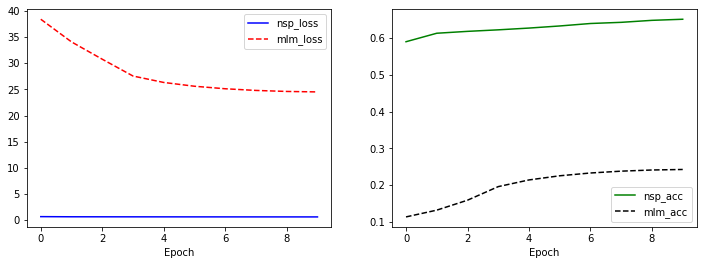

In [86]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

> 모델의 NSP와 MLM의 Loss는 안정적으로 감소하는 모습을 보여주었다.<br>
> NSP와 MLM와의 수치적 데이터 차이가 커서 Loss 그래프에서 NSP의 값이 제대로 출력되지 않는 모습을 보여주었다.<br>
> <br>
> 모델의 NSP와 MLM의 Accuracy는 안정적으로 증가하는 모습을 보여주었다.<br>
> NSP와 MLM와의 수치적 데이터 차이가 크지않아, Accuracy 그래프에서는 NSP의 값이 제대로 출력된 모습을 보여주었다.<br>

## 7.2 모델 성능 평가

> 이전에 생성한 테스트용 데이터셋을 활용하여 훈련된 모델의 성능을 테스트한다.<br>

In [87]:
pre_train_BERT_model.evaluate(pre_test_input, pre_test_label)

4/4 [==============================] - 1s 56ms/step - loss: 25.4810 - nsp_loss: 0.6524 - mlm_loss: 24.8286 - nsp_acc: 0.5500 - mlm_lm_acc: 0.2975


[25.48102378845215,
 0.6524033546447754,
 24.82862091064453,
 0.550000011920929,
 0.2975154519081116]

> 훈련된 모델을 테스트한 결과는 다음과 같다.<br>
> <br>
> loss: 25.4810<br>
> nsp_loss: 0.65243<br>
> mlm_loss: 24.8286<br>
> nsp_acc: 0.5500<br>
> mlm_lm_acc: 0.2975<br>

# 결론

> '나무위키' 도메인으로부터 수집한 한국어 데이터로 vocab size 8000, 약530만 규모의 학습 파라미터 사이즈로 구성된 BERT 모델을 10Epoch 학습시킨 결과는 아래 표와 같다.

|데이터 셋|Loss|NSP loss|NSP accuracy|MLM loss|MLM accuracy|
|------|------|------|------|------|------|
|Train dataset|25.1228|0.5983|0.6515|24.5245|0.2428|
|Test dataset|25.4810|0.6524|0.55|24.8286|0.2975|

> 최종 손실 함수는 훈련용 데이터와 테스트용 데이터 모두 25의 값을 기록했다.<br>
> NSP(문장 간 종속성)은 두 데이터 평균 60%대의 정확도를 보여주었고, loss rate도 낮은 모습을 확인할 수 있다.<br>
> MLM(일부 토큰 숨기기)는  데이터 평균 20%대의 정확도를 보여주었고, loss rate도 높은 모습을 확인할 수 있다.<br>
> MLM는 모델이 Masking된 단어를 예측할 때, vocabulary에서 1개만을 추출해야하므로, 예측 확률이 낮은 모습을 보여주었다고 생각한다.<br>